In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DateType
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
spark = SparkSession.builder.appName("ClassificationProject").getOrCreate()

# Loading the CSV file as Spark Dataframe


In [2]:
df1 = spark.read.csv("/content/drive/MyDrive/Datasets/consumercomplaints.csv", header=True, quote='"', escape='"', multiLine=True)


# Reading the Dataframe

In [3]:
df1.show(truncate=False)

+---+-------------+----------------------------------------------------------------------------+------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
df1.columns

['_c0',
 'Date received',
 'Product',
 'Sub-product',
 'Issue',
 'Sub-issue',
 'Consumer complaint narrative']

In [5]:
df1.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub-issue: string (nullable = true)
 |-- Consumer complaint narrative: string (nullable = true)



# Total Number of Rows

In [6]:
df1.count()

3101969

# Dropping the Index Column

In [7]:
df2 = df1.drop("_c0")
df2.show()

+-------------+--------------------+--------------------+--------------------+--------------------+----------------------------+
|Date received|             Product|         Sub-product|               Issue|           Sub-issue|Consumer complaint narrative|
+-------------+--------------------+--------------------+--------------------+--------------------+----------------------------+
|   2022-11-11|            Mortgage|Conventional home...|Trouble during pa...|                NULL|                        NULL|
|   2022-11-23|Credit reporting,...|    Credit reporting|Improper use of y...|Reporting company...|                        NULL|
|   2022-11-16|            Mortgage|         VA mortgage|Trouble during pa...|                NULL|                        NULL|
|   2022-11-15|Checking or savin...|    Checking account| Managing an account|         Fee problem|        Hi, I have been b...|
|   2022-11-07|            Mortgage|Other type of mor...|Trouble during pa...|                NUL

# Renaming the Columns

In [8]:
df3 = df2.withColumnsRenamed({"Date received": "Date_Received", "Sub-product": "Sub_Product", "Sub-issue": "Sub_Issue", "Consumer complaint narrative": "Complaint"})
df3.show()


+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Date_Received|             Product|         Sub_Product|               Issue|           Sub_Issue|           Complaint|
+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   2022-11-11|            Mortgage|Conventional home...|Trouble during pa...|                NULL|                NULL|
|   2022-11-23|Credit reporting,...|    Credit reporting|Improper use of y...|Reporting company...|                NULL|
|   2022-11-16|            Mortgage|         VA mortgage|Trouble during pa...|                NULL|                NULL|
|   2022-11-15|Checking or savin...|    Checking account| Managing an account|         Fee problem|Hi, I have been b...|
|   2022-11-07|            Mortgage|Other type of mor...|Trouble during pa...|                NULL|                NULL|
|   2022-11-13|Credit reporting,

# Converting the Data type of Date_Received column

In [9]:
df4 = df3.withColumn("Date_Received", df3["Date_Received"].cast(DateType()))

In [10]:
df4.printSchema()

root
 |-- Date_Received: date (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub_Product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub_Issue: string (nullable = true)
 |-- Complaint: string (nullable = true)



# Statistical Summary of Data

In [11]:
df4.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|             Product|         Sub_Product|               Issue|           Sub_Issue|           Complaint|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|             3101969|             2866675|             3101969|             2418614|             1113992|
|   mean|                NULL|                NULL|                NULL|                NULL|                NULL|
| stddev|                NULL|                NULL|                NULL|                NULL|                NULL|
|    min|Bank account or s...|(CD) Certificate ...|APR or interest rate|Account informati...|! ) forced placed...|
|    max|    Virtual currency|    Virtual currency|Wrong amount char...|You told them to ...|•\tSchool Loan se...|
+-------+--------------------+--------------------+--------------------+--------

# Count of Null-Values of each column

In [ ]:
null_value_count = {}
for col_ in df4.columns:
    null_count = df4.filter(df4[col_].isNull()).count()
    if null_count != 0:
      null_value_count[col_] = null_count
null_value_count

{'Sub_Product': 235294, 'Sub_Issue': 683355, 'Complaint': 1987977}

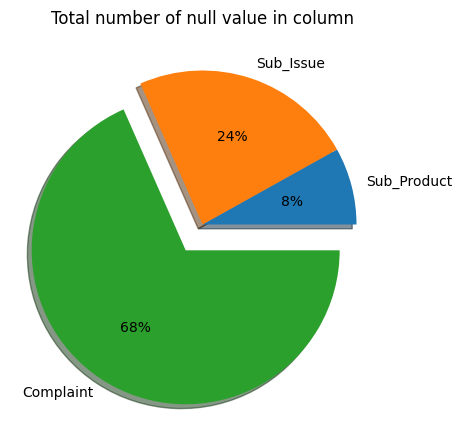

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
columns = list(null_value_count.keys())
values = list(null_value_count.values())
myexplode = [0, 0, 0.2]
plt.pie(values, labels=columns, shadow=True, explode=myexplode, autopct='%1.0f%%')
plt.title('Total number of null value in column')
plt.show()

# Count of Duplicate Rows

In [ ]:
df4.groupBy(df4.columns).count().where(col("count")>1).select(sum(col("count") - 1).alias("Total_Duplicates")).show()

+----------------+
|Total_Duplicates|
+----------------+
|         1676798|
+----------------+



# Treating the Null Values

In [12]:
df5 = df4.dropna()
df5.show()

+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Date_Received|             Product|         Sub_Product|               Issue|           Sub_Issue|           Complaint|
+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   2022-11-15|Checking or savin...|    Checking account| Managing an account|         Fee problem|Hi, I have been b...|
|   2022-11-09|     Debt collection|          Other debt|False statements ...|Indicated you wer...|XXXX is attemptin...|
|   2022-11-14|Credit reporting,...|    Credit reporting|Incorrect informa...|Account informati...|Today I called to...|
|   2022-10-12|Credit reporting,...|    Credit reporting|Problem with a cr...|Their investigati...|The Federal Trade...|
|   2022-10-09|Credit reporting,...|    Credit reporting|Problem with a cr...|Difficulty submit...|Ive mailed police...|
|   2022-10-16|Credit reporting,

In [ ]:
null_counts = df5.select([sum(col(c).isNull().cast("int")).alias(c) for c in df5.columns])
null_counts.show()

+-------------+-------+-----------+-----+---------+---------+
|Date_Received|Product|Sub_Product|Issue|Sub_Issue|Complaint|
+-------------+-------+-----------+-----+---------+---------+
|            0|      0|          0|    0|        0|        0|
+-------------+-------+-----------+-----+---------+---------+



# Duplicates after treating Null values

In [ ]:
df5.groupBy(df5.columns).count().where(col("count")>1).select(sum(col("count") - 1).alias("Total_Duplicates")).show()

+----------------+
|Total_Duplicates|
+----------------+
|          112286|
+----------------+



# Treating the Duplicate Rows

In [13]:
df6 = df5.dropDuplicates()
df6.count()

775522

# Univariate Analysis

In [ ]:
df6.groupBy('Product').count().show(truncate=False)

+----------------------------------------------------------------------------+------+
|Product                                                                     |count |
+----------------------------------------------------------------------------+------+
|Debt collection                                                             |185659|
|Checking or savings account                                                 |54154 |
|Credit card or prepaid card                                                 |80012 |
|Credit reporting, credit repair services, or other personal consumer reports|402254|
|Vehicle loan or lease                                                       |19802 |
|Student loan                                                                |32643 |
|Payday loan, title loan, or personal loan                                   |998   |
+----------------------------------------------------------------------------+------+



In [ ]:
df6.select('Complaint').distinct().count()

750208

In [ ]:
df6.show()

+-------------+--------------------+----------------+--------------------+--------------------+--------------------+
|Date_Received|             Product|     Sub_Product|               Issue|           Sub_Issue|           Complaint|
+-------------+--------------------+----------------+--------------------+--------------------+--------------------+
|   2022-11-15|Credit reporting,...|Credit reporting|Incorrect informa...|Account informati...|I started the dis...|
|   2022-08-19|Credit reporting,...|Credit reporting|Problem with a cr...|Investigation too...|This is NOT A DUP...|
|   2022-11-03|Vehicle loan or l...|            Loan|Struggling to pay...|Lender trying to ...|i made a pyment a...|
|   2022-09-07|Credit reporting,...|Credit reporting|Problem with a cr...|Their investigati...|Earlier this year...|
|   2022-10-27|Credit reporting,...|Credit reporting|Incorrect informa...|Account status in...|Citibank offered ...|
|   2022-11-02|Credit reporting,...|Credit reporting|Problem wit

In [ ]:
df6.groupBy('Issue').count().show(truncate=False)

+-------------------------------------------------------------+------+
|Issue                                                        |count |
+-------------------------------------------------------------+------+
|Communication tactics                                        |20163 |
|Problem with an overdraft                                    |4     |
|Getting a loan or lease                                      |2578  |
|Getting a loan                                               |680   |
|Problem with a company's investigation into an existing issue|1172  |
|Problem caused by your funds being low                       |3599  |
|Improper use of your report                                  |75029 |
|Problem with a lender or other company charging your account |6330  |
|Improper contact or sharing of info                          |2854  |
|Opening an account                                           |6212  |
|Other features, terms, or problems                           |10013 |
|Getti

In [ ]:
df6.select('Issue').distinct().count()

46

In [ ]:
df6.groupBy('Sub_Issue').count().show(truncate=False)

+-------------------------------------------------------------------+-----+
|Sub_Issue                                                          |count|
+-------------------------------------------------------------------+-----+
|Banking errors                                                     |3483 |
|Privacy issues                                                     |473  |
|Can't get flexible payment options                                 |995  |
|Transaction was not authorized                                     |5018 |
|Problem getting your free annual credit report                     |2895 |
|Can't temporarily postpone payments                                |501  |
|Indicated shouldn't respond to lawsuit                             |136  |
|Problem when attempting to purchase vehicle at the end of the lease|175  |
|Old information reappears or never goes away                       |8029 |
|Account opened as a result of fraud                                |1997 |
|Late or oth

In [ ]:
df6.select('Sub_Issue').distinct().count()

196

# Save the Preprocessed Spark Dataframe into a CSV File

In [18]:
df6.coalesce(1).write.parquet("/content/drive/MyDrive/Datasets/PreProcessedData.parquet", mode="overwrite")